<a href="https://colab.research.google.com/github/hannahzafar/UMDAOSC650/blob/main/firstrnn_changes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense ,Dropout
import keras
from keras.src.preprocessing.sequence import TimeseriesGenerator
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# reading dataset from NOAA online
dataset = pd.read_csv(
    'http://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt',
    delim_whitespace=True)

In [3]:
# data features include seasons, year, total SST (C), and ONI (ENSO index)
dataset.head()

,SEAS,YR,TOTAL,ANOM
0,DJF,1950,24.72,-1.53
1,JFM,1950,25.17,-1.34
2,FMA,1950,25.75,-1.16
3,MAM,1950,26.12,-1.18
4,AMJ,1950,26.32,-1.07


In [ ]:
dataset.tail()

,SEAS,YR,TOTAL,ANOM
884,ASO,2023,28.32,1.56
885,SON,2023,28.49,1.78
886,OND,2023,28.60,1.92
887,NDJ,2023,28.57,1.95
888,DJF,2024,28.44,1.80


In [ ]:
# drop any nans
dataset = dataset.dropna(subset=["ANOM"])

In [4]:
# quick stats
dataset.describe()

,YR,TOTAL,ANOM
count,889.000000,889.000000,889.000000
mean,1986.542182,26.900157,0.011102
std,21.397005,0.943204,0.838484
min,1950.000000,24.380000,-2.030000
25%,1968.000000,26.230000,-0.570000
50%,1987.000000,26.950000,-0.050000
75%,2005.000000,27.540000,0.530000
max,2024.000000,29.260000,2.640000


<Axes: xlabel='YR'>

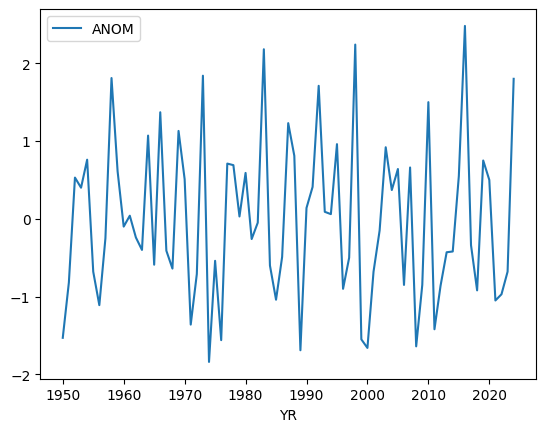

In [5]:
# quick viz
# djf only
dataset[dataset["SEAS"]=="DJF"].plot("YR","ANOM")

In [6]:
# train test split by years
trainds = dataset[dataset["YR"]<=2010]
testsds = dataset[dataset["YR"]>2010]

In [7]:
# grab anoms columns (ONI) and reset index
# reshape to be (samples, features)
# number of features here is just 1 (ONI)
trainds = trainds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)
testsds = testsds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)

In [8]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1))

In [9]:
# do rescaling
trainds_scaled = sc.fit_transform(trainds)
testsds_scaled = sc.transform(testsds)

In [10]:
# for help with data manipulation for time series rnn training; we can use the time series generator from keras

# dummy input for understanding
# data = np.array([[i] for i in range(50)])

# here goes our training data
data = trainds_scaled

# the shape of your target is your prediction shape (e.g., here we make it 4)
target = np.concatenate((np.roll(data, 0, axis=0),
                         np.roll(data, -1, axis=0),
                         np.roll(data, -2, axis=0),
                         np.roll(data, -3, axis=0)
                        ), axis=1)

# the length of the input feature
n_input=4
n_features=data.shape[1]

# this is the generator that will go into our rnn for training
data_gen = TimeseriesGenerator(data,
                               target,
                               length=n_input,
                               sampling_rate=1,
                               batch_size=16,
                               shuffle=True)

In [12]:
target.shape

(732, 4)

In [13]:
# quick check of output
batch_0 = data_gen[0]
x, y = batch_0
print(x[0], y[0])
print(x.shape, y.shape)

[[0.69751693]
 [0.67268623]
 [0.6772009 ]
 [0.73363431]] [0.79909707 0.84198646 0.83069977 0.79232506]
(16, 4, 1) (16, 4)


In [14]:
# lets make our rnn!
regressor = Sequential()
# LSTM with just one memory state (units=1)
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(n_input, n_features)))
# one neuron for output prediction
regressor.add(Dense(1))
# compile model
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
# what does graph look like?
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 100)            40800     
                                                                 
 dense (Dense)               (None, 4, 1)              101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# train the lstm!
regressor.fit(data_gen, epochs=100)

Epoch 1/100
46/46 [==============================] - 3s 5ms/step - loss: 0.1050 - mse: 0.1050 - mae: 0.2609
Epoch 2/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0397 - mse: 0.0397 - mae: 0.1537
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0302 - mse: 0.0302 - mae: 0.1370
Epoch 4/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0257 - mse: 0.0257 - mae: 0.1241
Epoch 5/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0217 - mse: 0.0217 - mae: 0.1161
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0229 - mse: 0.0229 - mae: 0.1175
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0218 - mse: 0.0218 - mae: 0.1155
Epoch 8/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0219 - mse: 0.0219 - mae: 0.1150
Epoch 9/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0197 - mse: 0.0197 - mae: 0.1095
Epoch 10/100
46/46 [========

In [16]:
# here goes our testing data
testdata = testsds_scaled

testtarget = np.concatenate((
    np.roll(testdata, 0, axis=0),
    np.roll(testdata, -1, axis=0),
    np.roll(testdata, -2, axis=0),
    np.roll(testdata, -3, axis=0)
    ), axis=1)

testdata_gen = TimeseriesGenerator(
    testdata,
    testtarget,
    length=n_input,
    sampling_rate=1,
    batch_size=testdata.shape[0], # all samples
    shuffle=False)

In [17]:
# quick check of output
batch_0 = testdata_gen[0]
x, y = batch_0
print(x[0], y[0])
print(x.shape, y.shape)

[[0.13769752]
 [0.18961625]
 [0.248307  ]
 [0.29345372]] [0.33408578 0.35891648 0.34988713 0.31828442]
(153, 4, 1) (153, 4)


In [18]:
oni_predictions = regressor.predict(testdata_gen)

1/1 [==============================] - 1s 502ms/step


In [19]:
print(oni_predictions.shape, y[:,0].shape)

(153, 4, 1) (153,)


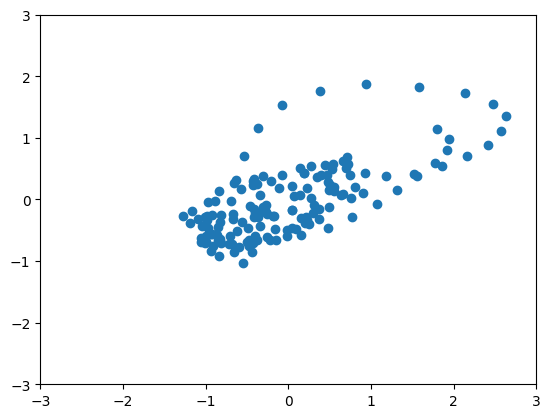

In [20]:
# how did we do!?
leadmonth = 0
plt.scatter(
    sc.inverse_transform(y[:,leadmonth].reshape(-1, 1)),
    sc.inverse_transform(oni_predictions[:,leadmonth,0].reshape(-1, 1))
    )
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

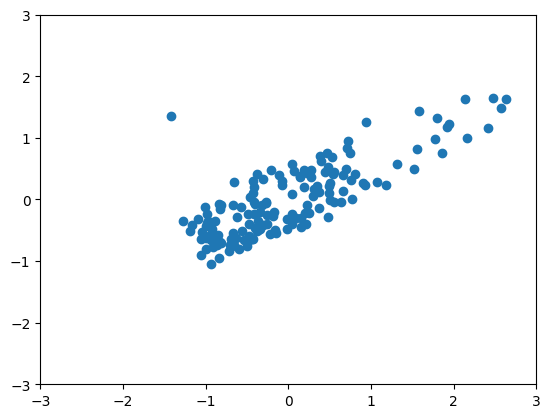

In [23]:
# how did we do!?
leadmonth = 1
plt.scatter(
    sc.inverse_transform(y[:,leadmonth].reshape(-1, 1)),
    sc.inverse_transform(oni_predictions[:,leadmonth,0].reshape(-1, 1))
    )
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

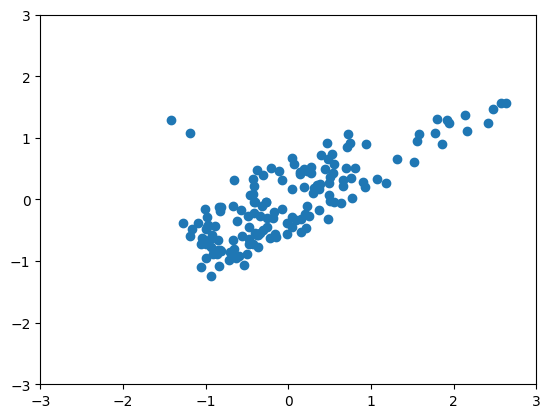

In [22]:
# how did we do!?
leadmonth = 2
plt.scatter(
    sc.inverse_transform(y[:,leadmonth].reshape(-1, 1)),
    sc.inverse_transform(oni_predictions[:,leadmonth,0].reshape(-1, 1))
    )
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

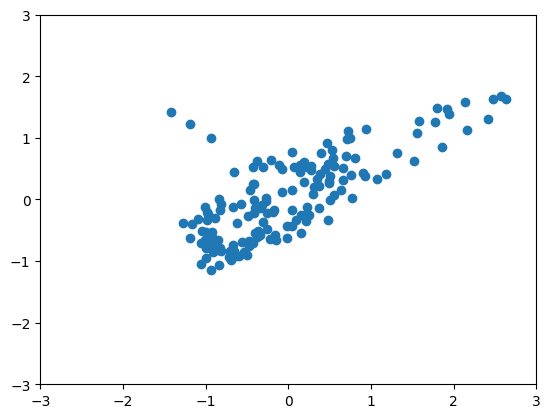

In [21]:
# how did we do!?
leadmonth = 3
plt.scatter(
    sc.inverse_transform(y[:,leadmonth].reshape(-1, 1)),
    sc.inverse_transform(oni_predictions[:,leadmonth,0].reshape(-1, 1))
    )
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()